# Text classification with Transformer Encoder

Adrian P. Bustamante

adrianpebus@gmail.com

### __Table of Contents__

<ol>
    <li><a href="#Objective">Objective</a></li>
    <li><a href="#Data-Processing">Data Processing</a></li>
    <li><a href="#Classifying-text-using-bag-of-embeddings">Classifying text using bag of embeddings</a></li>
    <li><a href="#Classifying-text-using-Transformer-Encoder">Classifying text using Transformer Encoder</a></li>
    <li><a href="#Conclusion">Conclusion</a></li>
</ol>

## Objective

The aim of this notebook is to do text classification for the AG_news dataset (a similar procedure can be use to perform sentiment analysis). We build and train two different models: first we use only a bag of embedding to perform the classification, the second model we use is a Transforeme encoder architecture. 

We train the model in a reduced dataset, due to the fact that the models are trained on cpu. 

## Data Processing

#### Importing libraries, defining utility methods

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('dark_background')

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
import pickle

from torch.nn.utils.rnn import pad_sequence

#print(torch.__version__)
#print(torchtext.__version__)

In [3]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

def plot(COST,ACC, title = 'no title'):
    
    fig, ax1 = plt.subplots()
    plt.suptitle(title)
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

##### using gpu, if available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### Importing dataset

In [5]:
# Import train and test sets
train_iter, test_iter = AG_NEWS()

for i, news in enumerate(train_iter):
    print(news)
    if i==10:
        break

/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
(3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')
(3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")
(3, 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.')
(3, 'Oil prices soar to all-time record, posing new menace t

#### labels and number of classes

In [6]:
num_class = len(set([label for (label, text) in train_iter ]))
print('number of classes =', num_class)

/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


number of classes = 4


In [7]:
##labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
y,text= next(iter(train_iter ))
print(y,text)
print('type of text: ',ag_news_label[y])

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
type of text:  Business


#### Defining tokenizer and vocabulary

In [8]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [9]:
print('Vocabulary size =', len(vocab) )

Vocabulary size = 95811


In [10]:
# Define functions to process text and labels
def text_pipeline(x):
    x=x.lower()# vocab is in lower case
    return vocab(tokenizer(x))
#labels start in zero
def label_pipeline(x):
    return int(x) - 1

#index to english function
index_to_en = lambda seq_en: " ".join([vocab.get_itos()[index] for index in seq_en])

#### Defining train and validation sets

In [11]:
#Convert the train and test iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
print('length of train set = ',len(split_train_))
print('length of validation set = ',len(split_valid_))
print('length of test set = ', len(test_dataset))

length of train set =  114000
length of validation set =  6000
length of test set =  7600


###### Comment the following block if you are using gpu

In [12]:
# we reduce the size of the train set since we work with cpu
if str(device) == 'cpu':
    print('No gpu available, computations are made on cpu. Reducing the size of data for training.')
    num_train = int(len(train_dataset) * 0.2)
    split_train_, _ = random_split(split_train_, [num_train, len(split_train_) - num_train])
    num_valid_ = int(len(split_valid_)*0.2)
    split_valid_, _ = random_split( split_valid_, [num_valid_, len(split_valid_) - num_valid_])
    print('length of train set = ',len(split_train_))
    print('length of validation set = ',len(split_valid_))
    print('length of test set = ', len(test_dataset))
    

No gpu available, computations are made on cpu. Reducing the size of data for training.
length of train set =  24000
length of validation set =  1200
length of test set =  7600


## Classifying text using bag of embeddings

#### Dataset and DataLoaders

In [13]:
## defining collate function to process batches
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [14]:
##defining DataLoaders
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [15]:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets###offsets mark the beginning of each sentence
##all the news in each batch are stack on a single one dim tensor

(tensor([3, 1, 2, 1, 0, 2, 3, 2, 2, 1, 1, 0, 2, 2, 2, 1, 0, 0, 0, 2, 3, 1, 1, 1,
         0, 2, 3, 2, 2, 0, 1, 0, 0, 3, 1, 3, 3, 2, 3, 1, 1, 3, 0, 0, 0, 2, 2, 3,
         1, 0, 2, 1, 0, 1, 1, 0, 2, 0, 1, 3, 3, 2, 3, 2]),
 tensor([14087,  2051,   478,  ...,     3,  2390,     1]),
 tensor([   0,   76,  110,  133,  164,  197,  226,  271,  332,  372,  408,  445,
          475,  514,  564,  601,  648,  697,  743,  789,  829,  861,  913,  950,
          972, 1000, 1039, 1080, 1142, 1190, 1227, 1264, 1291, 1330, 1369, 1406,
         1450, 1489, 1557, 1597, 1634, 1677, 1719, 1816, 1872, 1907, 1950, 1993,
         2067, 2112, 2146, 2182, 2225, 2267, 2307, 2357, 2394, 2442, 2469, 2504,
         2531, 2565, 2622, 2673]))

#### Defining Network

In [16]:
class TextClassEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassEmbedding, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [17]:
emsize=64 ##Size of the embedding
vocab_size = len(vocab)
print(f'Dimension embedding = {emsize}')
print(f'Vocabulary size = {vocab_size}')

model_boe = TextClassEmbedding(vocab_size, emsize, num_class).to(device)
model_boe

Dimension embedding = 64
Vocabulary size = 95811


TextClassEmbedding(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

#### Function to make predictions

In [18]:
def predict_boe(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(1).item() + 1]

In [19]:
print("Sentence : 'I like sports' ")
print('Predictions with initialized model (not yet trained): ',
      predict_boe("I like sports", text_pipeline, model_boe) )

Sentence : 'I like sports' 
Predictions with initialized model (not yet trained):  Sci/Tec


#### Function to evaluate the model

In [20]:
def evaluate_boe(dataloader, model):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [21]:
print('Accuray on test data with initialized model (not yet trained):')
evaluate_boe(test_dataloader, model_boe)

Accuray on test data with initialized model (not yet trained):


0.26460526315789473

#### Training the model

In [22]:
LR=0.1
##optimizer, loss function, and lr scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_boe.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 18, gamma=0.1)

In [23]:
##training the model
EPOCHS = 50
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model_boe.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model_boe(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate_boe(valid_dataloader, model_boe)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model_boe.state_dict(), 'model_boe.pth')
    print('Epoch:', epoch, ', LR = ', torch.optim.lr_scheduler.StepLR.get_lr(scheduler),
          'Loss = ', cum_loss, 'Accuracy_val: ', accu_val)

  0%|                                                                                            | 0/50 [00:00<?, ?it/s]/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  2%|█▋                                                                                  | 1/50 [00:02<01:39,  2.04s/it]

Epoch: 1 , LR =  [0.1] Loss =  517.4307280778885 Accuracy_val:  0.32916666666666666


  4%|███▎                                                                                | 2/50 [00:04<01:43,  2.15s/it]

Epoch: 2 , LR =  [0.1] Loss =  507.9834963083267 Accuracy_val:  0.39416666666666667


  6%|█████                                                                               | 3/50 [00:06<01:38,  2.10s/it]

Epoch: 3 , LR =  [0.1] Loss =  498.5031530857086 Accuracy_val:  0.45916666666666667


  8%|██████▋                                                                             | 4/50 [00:08<01:34,  2.05s/it]

Epoch: 4 , LR =  [0.1] Loss =  488.08115589618683 Accuracy_val:  0.5025


 10%|████████▍                                                                           | 5/50 [00:10<01:33,  2.07s/it]

Epoch: 5 , LR =  [0.1] Loss =  476.57840526103973 Accuracy_val:  0.525


 12%|██████████                                                                          | 6/50 [00:12<01:31,  2.07s/it]

Epoch: 6 , LR =  [0.1] Loss =  463.82863652706146 Accuracy_val:  0.5475


 14%|███████████▊                                                                        | 7/50 [00:14<01:28,  2.05s/it]

Epoch: 7 , LR =  [0.1] Loss =  449.9392058849335 Accuracy_val:  0.5825


 16%|█████████████▍                                                                      | 8/50 [00:16<01:25,  2.03s/it]

Epoch: 8 , LR =  [0.1] Loss =  435.1223895549774 Accuracy_val:  0.5975


 18%|███████████████                                                                     | 9/50 [00:18<01:22,  2.00s/it]

Epoch: 9 , LR =  [0.1] Loss =  419.62950909137726 Accuracy_val:  0.6175


 20%|████████████████▌                                                                  | 10/50 [00:20<01:20,  2.00s/it]

Epoch: 10 , LR =  [0.1] Loss =  403.75398510694504 Accuracy_val:  0.63


 22%|██████████████████▎                                                                | 11/50 [00:22<01:17,  2.00s/it]

Epoch: 11 , LR =  [0.1] Loss =  387.7061019539833 Accuracy_val:  0.6558333333333334


 24%|███████████████████▉                                                               | 12/50 [00:24<01:18,  2.06s/it]

Epoch: 12 , LR =  [0.1] Loss =  371.77399629354477 Accuracy_val:  0.6775


 26%|█████████████████████▌                                                             | 13/50 [00:26<01:18,  2.11s/it]

Epoch: 13 , LR =  [0.1] Loss =  356.20282632112503 Accuracy_val:  0.69


 28%|███████████████████████▏                                                           | 14/50 [00:28<01:16,  2.12s/it]

Epoch: 14 , LR =  [0.1] Loss =  341.2853279709816 Accuracy_val:  0.7075


 30%|████████████████████████▉                                                          | 15/50 [00:31<01:15,  2.14s/it]

Epoch: 15 , LR =  [0.1] Loss =  327.090489923954 Accuracy_val:  0.7175


 32%|██████████████████████████▌                                                        | 16/50 [00:33<01:13,  2.16s/it]

Epoch: 16 , LR =  [0.1] Loss =  313.69002264738083 Accuracy_val:  0.7283333333333334


 34%|████████████████████████████▏                                                      | 17/50 [00:35<01:11,  2.17s/it]

Epoch: 17 , LR =  [0.1] Loss =  301.25264674425125 Accuracy_val:  0.74


 36%|█████████████████████████████▉                                                     | 18/50 [00:37<01:10,  2.21s/it]

Epoch: 18 , LR =  [0.1] Loss =  289.69102931022644 Accuracy_val:  0.7516666666666667


 38%|███████████████████████████████▌                                                   | 19/50 [00:40<01:08,  2.21s/it]

Epoch: 19 , LR =  [0.1] Loss =  278.93482995033264 Accuracy_val:  0.7625


 40%|█████████████████████████████████▏                                                 | 20/50 [00:42<01:06,  2.22s/it]

Epoch: 20 , LR =  [0.1] Loss =  268.9371289610863 Accuracy_val:  0.7716666666666666


 42%|██████████████████████████████████▊                                                | 21/50 [00:44<01:04,  2.21s/it]

Epoch: 21 , LR =  [0.1] Loss =  259.79381275177 Accuracy_val:  0.7833333333333333


 44%|████████████████████████████████████▌                                              | 22/50 [00:46<01:01,  2.20s/it]

Epoch: 22 , LR =  [0.1] Loss =  251.2922660112381 Accuracy_val:  0.785


 46%|██████████████████████████████████████▏                                            | 23/50 [00:48<00:59,  2.19s/it]

Epoch: 23 , LR =  [0.1] Loss =  243.46437910199165 Accuracy_val:  0.7958333333333333


 48%|███████████████████████████████████████▊                                           | 24/50 [00:50<00:56,  2.18s/it]

Epoch: 24 , LR =  [0.1] Loss =  236.23315098881721 Accuracy_val:  0.7975


 50%|█████████████████████████████████████████▌                                         | 25/50 [00:53<00:54,  2.18s/it]

Epoch: 25 , LR =  [0.1] Loss =  229.4958538711071 Accuracy_val:  0.7991666666666667


 52%|███████████████████████████████████████████▏                                       | 26/50 [00:55<00:52,  2.17s/it]

Epoch: 26 , LR =  [0.1] Loss =  223.25660571455956 Accuracy_val:  0.8075


 54%|████████████████████████████████████████████▊                                      | 27/50 [00:57<00:49,  2.17s/it]

Epoch: 27 , LR =  [0.1] Loss =  217.45814195275307 Accuracy_val:  0.8116666666666666


 56%|██████████████████████████████████████████████▍                                    | 28/50 [00:59<00:47,  2.16s/it]

Epoch: 28 , LR =  [0.1] Loss =  212.07760870456696 Accuracy_val:  0.815


 58%|████████████████████████████████████████████████▏                                  | 29/50 [01:01<00:45,  2.15s/it]

Epoch: 29 , LR =  [0.1] Loss =  207.0140832066536 Accuracy_val:  0.8175


 60%|█████████████████████████████████████████████████▊                                 | 30/50 [01:03<00:42,  2.14s/it]

Epoch: 30 , LR =  [0.1] Loss =  202.26981312036514 Accuracy_val:  0.82


 62%|███████████████████████████████████████████████████▍                               | 31/50 [01:05<00:40,  2.12s/it]

Epoch: 31 , LR =  [0.1] Loss =  197.85312244296074 Accuracy_val:  0.8191666666666667


 64%|█████████████████████████████████████████████████████                              | 32/50 [01:08<00:38,  2.13s/it]

Epoch: 32 , LR =  [0.1] Loss =  193.70529717206955 Accuracy_val:  0.825


 66%|██████████████████████████████████████████████████████▊                            | 33/50 [01:10<00:36,  2.14s/it]

Epoch: 33 , LR =  [0.1] Loss =  189.80864110589027 Accuracy_val:  0.8266666666666667


 68%|████████████████████████████████████████████████████████▍                          | 34/50 [01:12<00:36,  2.28s/it]

Epoch: 34 , LR =  [0.1] Loss =  186.18155547976494 Accuracy_val:  0.8283333333333334


 70%|██████████████████████████████████████████████████████████                         | 35/50 [01:15<00:33,  2.24s/it]

Epoch: 35 , LR =  [0.1] Loss =  182.6917945444584 Accuracy_val:  0.83


 72%|███████████████████████████████████████████████████████████▊                       | 36/50 [01:17<00:31,  2.25s/it]

Epoch: 36 , LR =  [0.1] Loss =  179.40830793976784 Accuracy_val:  0.8308333333333333


 74%|█████████████████████████████████████████████████████████████▍                     | 37/50 [01:19<00:29,  2.30s/it]

Epoch: 37 , LR =  [0.1] Loss =  176.27862405776978 Accuracy_val:  0.8341666666666666


 76%|███████████████████████████████████████████████████████████████                    | 38/50 [01:21<00:27,  2.25s/it]

Epoch: 38 , LR =  [0.1] Loss =  173.28518164157867 Accuracy_val:  0.8416666666666667


 78%|████████████████████████████████████████████████████████████████▋                  | 39/50 [01:23<00:24,  2.22s/it]

Epoch: 39 , LR =  [0.1] Loss =  170.49567985534668 Accuracy_val:  0.8433333333333334


 80%|██████████████████████████████████████████████████████████████████▍                | 40/50 [01:26<00:22,  2.20s/it]

Epoch: 40 , LR =  [0.1] Loss =  167.83947831392288 Accuracy_val:  0.8441666666666666


 82%|████████████████████████████████████████████████████████████████████               | 41/50 [01:28<00:19,  2.18s/it]

Epoch: 41 , LR =  [0.1] Loss =  165.26033726334572 Accuracy_val:  0.8458333333333333


 84%|█████████████████████████████████████████████████████████████████████▋             | 42/50 [01:30<00:17,  2.18s/it]

Epoch: 42 , LR =  [0.1] Loss =  162.84799441695213 Accuracy_val:  0.85


 86%|███████████████████████████████████████████████████████████████████████▍           | 43/50 [01:32<00:15,  2.17s/it]

Epoch: 43 , LR =  [0.1] Loss =  160.48250076174736 Accuracy_val:  0.8516666666666667


 88%|█████████████████████████████████████████████████████████████████████████          | 44/50 [01:34<00:12,  2.16s/it]

Epoch: 44 , LR =  [0.1] Loss =  158.25948445498943 Accuracy_val:  0.8533333333333334


 90%|██████████████████████████████████████████████████████████████████████████▋        | 45/50 [01:36<00:10,  2.15s/it]

Epoch: 45 , LR =  [0.1] Loss =  156.14222052693367 Accuracy_val:  0.8558333333333333


 92%|████████████████████████████████████████████████████████████████████████████▎      | 46/50 [01:39<00:08,  2.16s/it]

Epoch: 46 , LR =  [0.1] Loss =  154.07164554297924 Accuracy_val:  0.8566666666666667


 94%|██████████████████████████████████████████████████████████████████████████████     | 47/50 [01:41<00:06,  2.15s/it]

Epoch: 47 , LR =  [0.1] Loss =  152.10984510183334 Accuracy_val:  0.8583333333333333


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:43<00:04,  2.15s/it]

Epoch: 48 , LR =  [0.1] Loss =  150.20728535950184 Accuracy_val:  0.8575


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:45<00:02,  2.14s/it]

Epoch: 49 , LR =  [0.1] Loss =  148.34273426234722 Accuracy_val:  0.86


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.15s/it]

Epoch: 50 , LR =  [0.1] Loss =  146.63745617866516 Accuracy_val:  0.8608333333333333


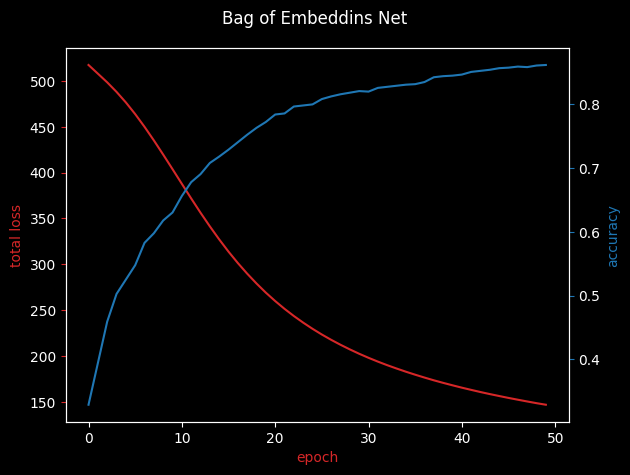

In [25]:
plot(cum_loss_list,acc_epoch, title = 'Bag of Embeddins Net')

In [26]:
print('Accuray on test set for trained model = ', evaluate_boe(test_dataloader, model_boe) )

Accuray on test set for trained model =  0.8477631578947369


#### Making some predictions on the Test set

In [27]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

result = predict_boe(article, text_pipeline, model_boe)
result

'Sports'

In [28]:
y,x,offsets = next(iter(test_dataloader))
output = model_boe(x, offsets)

for i in range(len(offsets)-1):
    #output = model_(torch.unsqueeze(x[i],0).to(device))
    #output = model(x, offsets)
    pred_label = ag_news_label[output.argmax(1)[i].item() +1]
    print( 'Predicted label: ', pred_label)
    print( 'True label: ', ag_news_label[y[i].item()+ 1])
    print( 'Text: ', index_to_en(x[offsets[i].item():offsets[i+1].item()]))
    print('----------------------- \n')
    if i==15:
        break

Predicted label:  Sports
True label:  Sports
Text:  liverpool #39 s benitez hopes to sign new striker liverpool manager rafael benitez would like to sign a new striker in january #39 s transfer window after an injured djibril cisse was sidelined for the rest of the season but warned he would not break the bank to sign someone .
----------------------- 

Predicted label:  Business
True label:  Business
Text:  cvs profit slips as eckerd expenses weigh cvs corp . ( cvs . n quote , profile , research ) , the no . 2 us drugstore chain , on thursday reported a lower quarterly profit as it grappled with expenses tied to its recent purchase of eckerd drug stores from jc penney co .
----------------------- 

Predicted label:  Sports
True label:  Sports
Text:  pudge , guillen leave with injuries the tigers lost both of their all-stars , shortstop carlos guillen and catcher ivan rodriguez , to knee injuries on separate plays in saturday #39 s game against the twins .
----------------------- 

Pre

## Classifying text using Transformer Encoder

#### DataLoaders

In [29]:
def collate_batch_trans(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)  ###padding to sequences on the batch
    ###pads the sequence with <unk> token

    return label_list.to(device), text_list.to(device)

In [30]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_trans
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_trans
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_trans
)

In [31]:
label,sequence=next(iter(valid_dataloader ))
print(label) ##batch size
print(sequence) ###batch_size, sequence size

tensor([0, 3, 0, 0, 2, 2, 2, 1, 0, 0, 1, 2, 3, 1, 1, 3, 0, 0, 0, 3, 1, 0, 2, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 2, 1, 3, 0, 1, 2, 2, 3, 2, 1, 3, 0, 0, 1, 0, 3,
        1, 1, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 0, 3, 1, 2])
tensor([[ 2556,   722,  8188,  ...,     0,     0,     0],
        [ 1321,  2228,    11,  ...,     0,     0,     0],
        [  618,    33, 19488,  ...,     0,     0,     0],
        ...,
        [  312,  2599,   368,  ...,     0,     0,     0],
        [ 1230,  3939,    11,  ...,     0,     0,     0],
        [  838,     4, 24074,  ...,     0,     0,     0]])


#### Positional Encoding

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)### no training, no gradients

    def forward(self, x): ##x: batch_size, sequence_size, d_model
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

#### Defining Transformer Encoder Network

In [33]:
class TransformerEncoder(nn.Module):
    """
    Text classifier based on a TransformerEncoder.
    """
    def __init__(
        self,
        vocab_size,
        num_class,
        #embedding_dim=300, ###pretrained embedding
        embedding_dim=64, ##training the embedding
        nhead=4,
        #nhead=5,
        #dim_feedforward=2048,
        dim_feedforward = 256,
        num_layers=3,
        #num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()
        #self.emb = nn.Embedding(vocab_size,embedding_dim)
        #self.embedding = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
        self.embedding = nn.Embedding(vocab_size,embedding_dim)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()


    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [34]:
model_trans = TransformerEncoder(vocab_size=vocab_size,num_class=4).to(device)
model_trans

/home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerEncoder(
  (embedding): Embedding(95811, 64)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=64, out_features=4, bias=True)
)

#### function to make predictions

In [35]:
def predict_trans(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

In [36]:
print("Sentence : 'I like sports' ")
print('Predictions with initialized model (not yet trained): ',predict_trans("I like sports",text_pipeline,model_trans))

Sentence : 'I like sports' 
Predictions with initialized model (not yet trained):  Sci/Tec


#### Function to evaluate the model

In [37]:
def evaluate_trans(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [38]:
print('Accuracy on test set of initial model (not yet trained) = ', evaluate_trans(test_dataloader, model_trans)) ###evalutation without training

Accuracy on test set of initial model (not yet trained) =  0.25


#### Training

In [39]:
pytorch_total_params = sum(p.numel() for p in model_trans.parameters() if p.requires_grad)
print('Number of trainable parameters =', pytorch_total_params )

Number of trainable parameters = 6282116


In [40]:
##learning rates
LR=0.1

criterion = torch.nn.CrossEntropyLoss() #loss function
optimizer = torch.optim.SGD(model_trans.parameters(), lr=LR) ##optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=18, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [41]:
EPOCHS = 50
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model_trans.train()
    cum_loss=0
    for idx, (label, text) in enumerate(train_dataloader):
        optimizer.zero_grad()
        label, text=label.to(device), text.to(device)


        predicted_label = model_trans(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()
    print("Loss_train = ",cum_loss)
    #print('Learning rate = ',torch.optim.lr_scheduler.StepLR.get_last_lr(scheduler))

    cum_loss_list.append(cum_loss)
    accu_val = evaluate_trans(valid_dataloader, model_trans)
    acc_epoch.append(accu_val)
    print('Accuracy_validation= ', accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model_trans.state_dict(), 'model_trans_enc.pth')

save_list_to_file(lst=cum_loss_list, filename="model_trans_enc.pkl")
save_list_to_file(lst=acc_epoch, filename="model_trans_enc.pkl")

  0%|                                                                                            | 0/50 [00:00<?, ?it/s]

Loss_train =  549.5552048683167


  2%|█▋                                                                                  | 1/50 [00:26<21:54, 26.83s/it]

Accuracy_validation=  0.32083333333333336
Loss_train =  468.8352457880974


  4%|███▎                                                                                | 2/50 [00:54<21:45, 27.20s/it]

Accuracy_validation=  0.4725
Loss_train =  402.7256635427475


  6%|█████                                                                               | 3/50 [01:22<21:32, 27.49s/it]

Accuracy_validation=  0.5858333333333333
Loss_train =  350.75664710998535


  8%|██████▋                                                                             | 4/50 [01:49<21:06, 27.53s/it]

Accuracy_validation=  0.7058333333333333
Loss_train =  309.51423877477646


 10%|████████▍                                                                           | 5/50 [02:16<20:24, 27.21s/it]

Accuracy_validation=  0.7341666666666666
Loss_train =  277.0105889439583


 12%|██████████                                                                          | 6/50 [02:43<19:55, 27.17s/it]

Accuracy_validation=  0.7575
Loss_train =  252.03474986553192


 14%|███████████▊                                                                        | 7/50 [03:10<19:20, 27.00s/it]

Accuracy_validation=  0.7866666666666666
Loss_train =  231.3168703019619


 16%|█████████████▍                                                                      | 8/50 [03:37<18:58, 27.10s/it]

Accuracy_validation=  0.8033333333333333
Loss_train =  211.30681665241718


 18%|███████████████                                                                     | 9/50 [04:04<18:28, 27.03s/it]

Accuracy_validation=  0.8166666666666667
Loss_train =  197.87108778953552


 20%|████████████████▌                                                                  | 10/50 [04:31<17:57, 26.94s/it]

Accuracy_validation=  0.8216666666666667
Loss_train =  186.74413965642452


 22%|██████████████████▎                                                                | 11/50 [04:57<17:29, 26.92s/it]

Accuracy_validation=  0.8341666666666666
Loss_train =  175.56693969666958


 24%|███████████████████▉                                                               | 12/50 [05:24<16:59, 26.82s/it]

Accuracy_validation=  0.8316666666666667
Loss_train =  170.34520816802979


 26%|█████████████████████▌                                                             | 13/50 [05:51<16:32, 26.83s/it]

Accuracy_validation=  0.8241666666666667
Loss_train =  159.59837220609188


 28%|███████████████████████▏                                                           | 14/50 [06:17<16:02, 26.75s/it]

Accuracy_validation=  0.8516666666666667
Loss_train =  153.06233431398869


 30%|████████████████████████▉                                                          | 15/50 [06:44<15:35, 26.72s/it]

Accuracy_validation=  0.86
Loss_train =  146.23731826245785


 32%|██████████████████████████▌                                                        | 16/50 [07:11<15:08, 26.71s/it]

Accuracy_validation=  0.8508333333333333
Loss_train =  141.1906017959118


 34%|████████████████████████████▏                                                      | 17/50 [07:37<14:41, 26.71s/it]

Accuracy_validation=  0.8458333333333333
Loss_train =  135.45897889137268


 36%|█████████████████████████████▉                                                     | 18/50 [08:04<14:12, 26.65s/it]

Accuracy_validation=  0.8533333333333334
Loss_train =  129.8002252280712


 38%|███████████████████████████████▌                                                   | 19/50 [08:31<13:47, 26.69s/it]

Accuracy_validation=  0.8633333333333333
Loss_train =  127.10729876160622


 40%|█████████████████████████████████▏                                                 | 20/50 [08:58<13:21, 26.71s/it]

Accuracy_validation=  0.8675
Loss_train =  121.45629844069481


 42%|██████████████████████████████████▊                                                | 21/50 [09:24<12:53, 26.67s/it]

Accuracy_validation=  0.8525
Loss_train =  121.07505015283823


 44%|████████████████████████████████████▌                                              | 22/50 [09:51<12:27, 26.71s/it]

Accuracy_validation=  0.8658333333333333
Loss_train =  115.68430642038584


 46%|██████████████████████████████████████▏                                            | 23/50 [10:17<11:57, 26.58s/it]

Accuracy_validation=  0.8633333333333333
Loss_train =  110.80434945970774


 48%|███████████████████████████████████████▊                                           | 24/50 [10:44<11:31, 26.59s/it]

Accuracy_validation=  0.8716666666666667
Loss_train =  108.2894944474101


 50%|█████████████████████████████████████████▌                                         | 25/50 [11:11<11:07, 26.69s/it]

Accuracy_validation=  0.8558333333333333
Loss_train =  103.73578117787838


 52%|███████████████████████████████████████████▏                                       | 26/50 [11:37<10:40, 26.71s/it]

Accuracy_validation=  0.8625
Loss_train =  104.07763428241014


 54%|████████████████████████████████████████████▊                                      | 27/50 [12:05<10:19, 26.95s/it]

Accuracy_validation=  0.8708333333333333
Loss_train =  97.28155791014433


 56%|██████████████████████████████████████████████▍                                    | 28/50 [12:31<09:48, 26.75s/it]

Accuracy_validation=  0.8675
Loss_train =  94.96975962072611


 58%|████████████████████████████████████████████████▏                                  | 29/50 [12:58<09:19, 26.62s/it]

Accuracy_validation=  0.8783333333333333
Loss_train =  93.46105827391148


 60%|█████████████████████████████████████████████████▊                                 | 30/50 [13:24<08:50, 26.52s/it]

Accuracy_validation=  0.8691666666666666
Loss_train =  90.68617445603013


 62%|███████████████████████████████████████████████████▍                               | 31/50 [13:50<08:22, 26.46s/it]

Accuracy_validation=  0.8708333333333333
Loss_train =  89.82306805998087


 64%|█████████████████████████████████████████████████████                              | 32/50 [14:17<07:55, 26.44s/it]

Accuracy_validation=  0.8816666666666667
Loss_train =  86.8908370025456


 66%|██████████████████████████████████████████████████████▊                            | 33/50 [14:43<07:29, 26.42s/it]

Accuracy_validation=  0.875
Loss_train =  83.70078542083502


 68%|████████████████████████████████████████████████████████▍                          | 34/50 [15:09<07:01, 26.36s/it]

Accuracy_validation=  0.87
Loss_train =  84.10414713993669


 70%|██████████████████████████████████████████████████████████                         | 35/50 [15:35<06:34, 26.31s/it]

Accuracy_validation=  0.8758333333333334
Loss_train =  81.69905377179384


 72%|███████████████████████████████████████████████████████████▊                       | 36/50 [16:02<06:08, 26.34s/it]

Accuracy_validation=  0.8758333333333334
Loss_train =  78.89408769086003


 74%|█████████████████████████████████████████████████████████████▍                     | 37/50 [16:28<05:42, 26.34s/it]

Accuracy_validation=  0.8766666666666667
Loss_train =  77.1418106853962


 76%|███████████████████████████████████████████████████████████████                    | 38/50 [16:54<05:15, 26.29s/it]

Accuracy_validation=  0.8741666666666666
Loss_train =  73.02240241318941


 78%|████████████████████████████████████████████████████████████████▋                  | 39/50 [17:20<04:48, 26.21s/it]

Accuracy_validation=  0.8708333333333333
Loss_train =  73.7932951040566


 80%|██████████████████████████████████████████████████████████████████▍                | 40/50 [17:46<04:21, 26.17s/it]

Accuracy_validation=  0.8758333333333334
Loss_train =  72.65476440265775


 82%|████████████████████████████████████████████████████████████████████               | 41/50 [18:12<03:55, 26.12s/it]

Accuracy_validation=  0.8741666666666666
Loss_train =  68.4298115260899


 84%|█████████████████████████████████████████████████████████████████████▋             | 42/50 [18:39<03:29, 26.20s/it]

Accuracy_validation=  0.8783333333333333
Loss_train =  68.29180112108588


 86%|███████████████████████████████████████████████████████████████████████▍           | 43/50 [19:05<03:03, 26.27s/it]

Accuracy_validation=  0.8691666666666666
Loss_train =  65.17393782734871


 88%|█████████████████████████████████████████████████████████████████████████          | 44/50 [19:32<02:37, 26.29s/it]

Accuracy_validation=  0.875
Loss_train =  64.73698749579489


 90%|██████████████████████████████████████████████████████████████████████████▋        | 45/50 [19:58<02:11, 26.29s/it]

Accuracy_validation=  0.8716666666666667
Loss_train =  63.644412621855736


 92%|████████████████████████████████████████████████████████████████████████████▎      | 46/50 [20:24<01:45, 26.31s/it]

Accuracy_validation=  0.875
Loss_train =  61.54647824726999


 94%|██████████████████████████████████████████████████████████████████████████████     | 47/50 [20:51<01:18, 26.32s/it]

Accuracy_validation=  0.8833333333333333
Loss_train =  61.0957255102694


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 48/50 [21:17<00:52, 26.33s/it]

Accuracy_validation=  0.8716666666666667
Loss_train =  58.45308374799788


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [21:43<00:26, 26.31s/it]

Accuracy_validation=  0.875
Loss_train =  57.7623482234776


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [22:09<00:00, 26.60s/it]

Accuracy_validation=  0.87


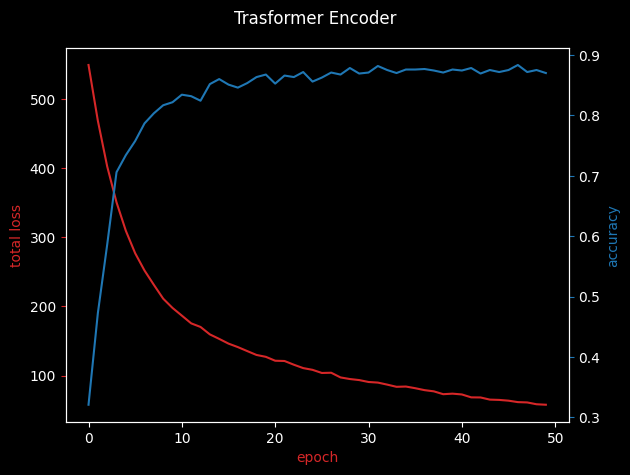

In [42]:
plot(cum_loss_list,acc_epoch, title = 'Trasformer Encoder')

In [43]:
print('Accuracy on test data for trained model = ',evaluate_trans(test_dataloader, model_trans))

Accuracy on test data for trained model =  0.8689473684210526


## Conclusion

Two different types of Networks were used to classify text. As expected, the transformer-encoder architecture yielded a higher accuracy on the test set. Since the models were trained on cpu, the size of the dataset needed to be reduced. Larger datasets can be considered if gpu's are used, as well as a deeper transformer-encoder architectures, which is expected to give better results. 